In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline

In [21]:
#Header information for project candidate 1: Red Wine Quality
df0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Files and Assignments/winequality-red.csv', sep=';')
pd.set_option('display.width',250)
pd.set_option('display.max_columns',15)
pd.set_option('display.min_rows', 50)
print(df0.shape)
print(df0.head(2))
print(df0.describe())
print(df0.info())

(1599, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  alcohol  quality
0            7.4              0.70          0.0             1.9      0.076                 11.0                  34.0   0.9978  3.51       0.56      9.4        5
1            7.8              0.88          0.0             2.6      0.098                 25.0                  67.0   0.9968  3.20       0.68      9.8        5
       fixed acidity  volatile acidity  citric acid  residual sugar    chlorides  free sulfur dioxide  total sulfur dioxide      density           pH    sulphates      alcohol      quality
count    1599.000000       1599.000000  1599.000000     1599.000000  1599.000000          1599.000000           1599.000000  1599.000000  1599.000000  1599.000000  1599.000000  1599.000000
mean        8.319637          0.527821     0.270976        2.538806     0.087467            15.874922             46.467792  

#Data Cleansing

In [22]:
print(df0.info())
print('\n\n Number of Duplicated Rows: ',df0.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


 Number of Duplicated Rows:  240


In [23]:
df_noquality = df0.drop(columns='quality')
print(df_noquality.shape)
print('Number of Duplicated Bottles: ', df_noquality.duplicated().sum())

(1599, 11)
Number of Duplicated Bottles:  240


In [24]:
df0 = df0.drop_duplicates()
print(df0.shape)

(1359, 12)


In [25]:
#Address Missing Values
df0.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [26]:
#For Loop to find outliers and inconsistent categories
counter = len(df0.loc[1,:])  
for x in range(counter):
  if df0.iloc[:,x].dtypes == 'int64':
    print('\n\n', df0.iloc[:,x].head(0))
    print('Min =', df0.iloc[:,x].min())
    print('Max =', df0.iloc[:,x].max())
    print('Mean =', df0.iloc[:,x].mean())
  if df0.iloc[:,x].dtypes == 'float64':
    print('\n\n', df0.iloc[:,x].head(0))
    print('Min =', df0.iloc[:,x].min())
    print('Max =', df0.iloc[:,x].max())
    print('Mean =', df0.iloc[:,x].mean())
  elif df0.iloc[:,x].dtypes == 'object':
    print('\n\n', df0.iloc[:,x].head(0))
    print('Categories: ', df0.iloc[:,x].value_counts())



 Series([], Name: fixed acidity, dtype: float64)
Min = 4.6
Max = 15.9
Mean = 8.310596026490087


 Series([], Name: volatile acidity, dtype: float64)
Min = 0.12
Max = 1.58
Mean = 0.5294775570272258


 Series([], Name: citric acid, dtype: float64)
Min = 0.0
Max = 1.0
Mean = 0.27233259749815975


 Series([], Name: residual sugar, dtype: float64)
Min = 0.9
Max = 15.5
Mean = 2.523399558498897


 Series([], Name: chlorides, dtype: float64)
Min = 0.012
Max = 0.611
Mean = 0.0881236203090504


 Series([], Name: free sulfur dioxide, dtype: float64)
Min = 1.0
Max = 72.0
Mean = 15.893303899926417


 Series([], Name: total sulfur dioxide, dtype: float64)
Min = 6.0
Max = 289.0
Mean = 46.82597498160412


 Series([], Name: density, dtype: float64)
Min = 0.99007
Max = 1.00369
Mean = 0.9967089477557026


 Series([], Name: pH, dtype: float64)
Min = 2.74
Max = 4.01
Mean = 3.309786607799856


 Series([], Name: sulphates, dtype: float64)
Min = 0.33
Max = 2.0
Mean = 0.6587049300956593


 Series([], Name: a

In [27]:
#Deeper look at potential outliers
temp1 = df0['volatile acidity'].sort_values(ascending=False)
temp2 = df0['residual sugar'].sort_values(ascending=False)
temp3 = df0['chlorides'].sort_values(ascending=False)
temp4 = df0['free sulfur dioxide'].sort_values(ascending=False)
temp5 = df0['total sulfur dioxide'].sort_values(ascending=False)
print(temp1.head())
print(temp2.head())
print(temp3.head())
print(temp4.head())
print(temp5.head())


1299    1.580
126     1.330
127     1.330
672     1.240
690     1.185
Name: volatile acidity, dtype: float64
480     15.5
1434    15.4
1574    13.9
1474    13.8
1244    13.4
Name: residual sugar, dtype: float64
258    0.611
151    0.610
106    0.467
81     0.464
692    0.422
Name: chlorides, dtype: float64
1244    72.0
396     68.0
1558    66.0
1131    57.0
1434    55.0
Name: free sulfur dioxide, dtype: float64
1081    289.0
1079    278.0
354     165.0
1244    160.0
651     155.0
Name: total sulfur dioxide, dtype: float64


#Exploratory Visualizations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4fccd6c10>,
      dtype=object)

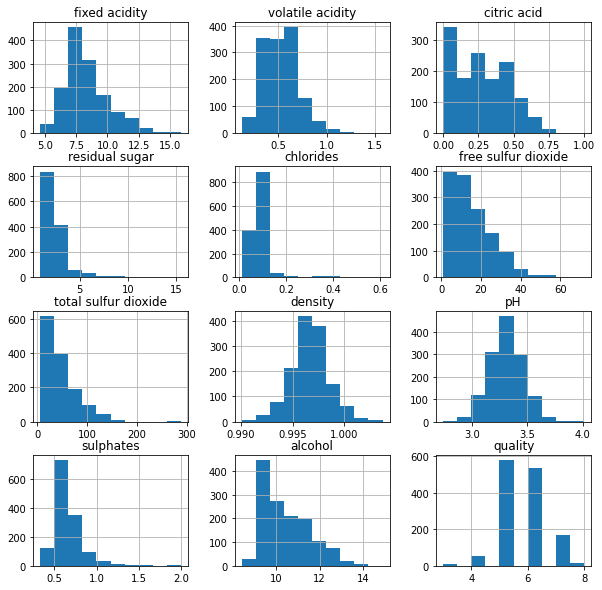

In [28]:
df0.hist(figsize=(10,10))

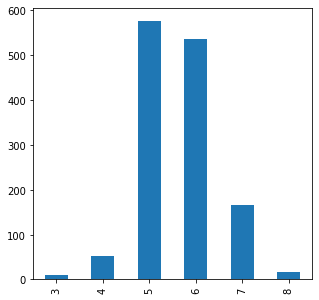

In [29]:
#Plot univariate distribution to find outliers
dftemp = df0.sort_values(by='quality')
plt.figure(figsize=(5,5))
dftemp['quality'].value_counts(sort=False).plot(kind = 'bar');
plt.show()

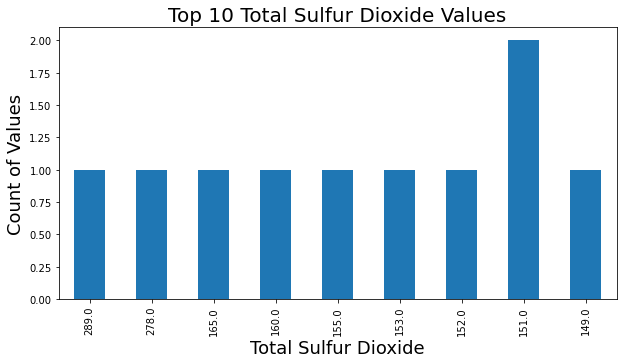

In [30]:
plt.figure(figsize=(10,5))
plt.xlabel('Total Sulfur Dioxide', fontsize=18)
plt.ylabel('Count of Values', fontsize=18)
plt.title('Top 10 Total Sulfur Dioxide Values', fontsize=20)
totalsulfur_sorted = dftemp['total sulfur dioxide'].sort_values()
totalsulfur_top10 = totalsulfur_sorted.nlargest(n=10)
totalsulfur_top10.value_counts(sort=False).plot(kind = 'bar');
plt.show()
#Distribution shows a range of values stepping to the maximum value


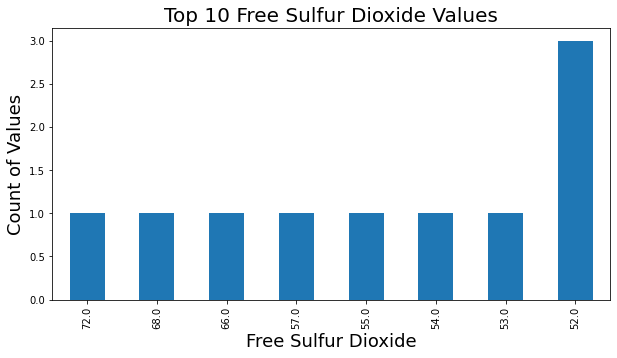

In [31]:
plt.figure(figsize=(10,5))
plt.xlabel('Free Sulfur Dioxide', fontsize=18)
plt.ylabel('Count of Values', fontsize=18)
plt.title('Top 10 Free Sulfur Dioxide Values', fontsize=20)
freesulfur_sorted = dftemp['free sulfur dioxide'].sort_values()
freesulfur_top10 = freesulfur_sorted.nlargest(n=10)
freesulfur_top10.value_counts(sort=False).plot(kind = 'bar');
plt.show()
#Distribution shows a range of values stepping to the maximum value

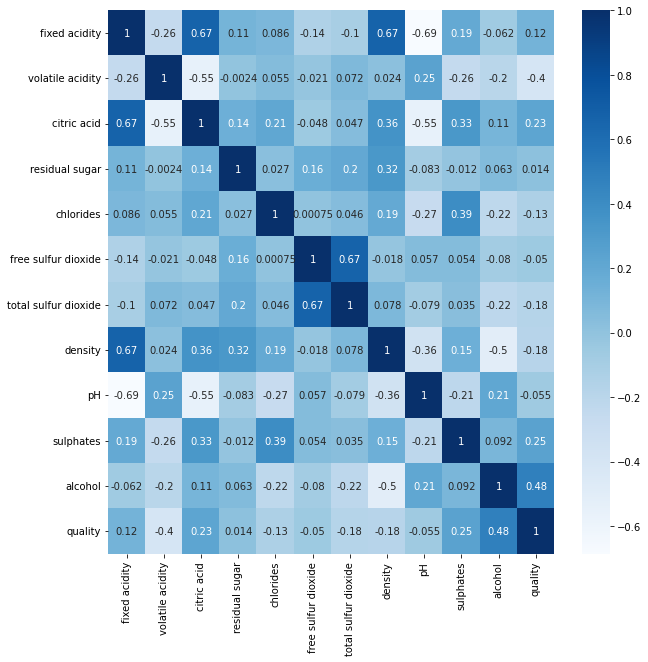

In [32]:
corr = df0.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap = 'Blues', annot=True)
#Only exhibits low correlation with alcohol and sulphates (alcohol scoring close to moderate correlation)

#Data Preprocessing and Pipelines

In [33]:
#Turn alcohol content in to binary categories as there is a bit of correlation towards quality and alcohol content
alc_median= df0['alcohol'].median()
df0['alcohol'] = df0['alcohol'].apply(lambda x: 'high' if x >= alc_median else 'low')
df0['alcohol'].value_counts()


high    683
low     676
Name: alcohol, dtype: int64

In [34]:
X = df0.drop(columns=['quality'])
y = df0['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
#I chose an ordinal encoder to encode the binary high/low alcohol content
ord = OrdinalEncoder()
scaler = StandardScaler()
num_tuple = (scaler, num_selector)
cat_tuple = (ord, cat_selector) 
preprocess_transformer = make_column_transformer(num_tuple, cat_tuple)


#Model Selection:
*   GradientBoost
*   RandomForest

These models were selected after previewing their performance in this section. Having scored the highest, we will later determine whether we are able to improve on their scores through hyperparameter tuning.

This was treated as a classification problem since there were finite categories of quality rankings.

In [35]:
#Function for Classification Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
def ClassificationBoost(X_train, X_test, y_train, y_test):
  gradientboost = GradientBoostingClassifier()
  gbc = make_pipeline(preprocess_transformer, gradientboost)
  gbc.fit(X_train, y_train)
  gbctrainpred = gbc.predict(X_train)
  gbctestpred = gbc.predict(X_test)
  print('---'*5, 'Created gbr model', '---'*5)
  print('Training accuracy:', gbc.score(X_train, y_train))
  print('Testing accuracy:', gbc.score(X_test, y_test))

  lgbmboost = LGBMClassifier()
  lgbm = make_pipeline(preprocess_transformer, lgbmboost)
  lgbm.fit(X_train, y_train)
  lgbmtrainpred = lgbm.predict(X_train)
  lgbmtestpred = lgbm.predict(X_test)
  print('---'*5, 'Created lgbm model', '---'*5)
  print('Training accuracy:', lgbm.score(X_train, y_train))
  print('Testing accuracy:', lgbm.score(X_test, y_test))

  xgbboost = XGBClassifier()
  xgb = make_pipeline(preprocess_transformer, xgbboost)
  xgb.fit(X_train, y_train)
  xgbtrainpred = xgb.predict(X_train)
  xgbtestpred = xgb.predict(X_test)
  print('---'*5, 'Created xgb model', '---'*5)
  print('Training accuracy:', xgb.score(X_train, y_train))
  print('Testing accuracy:', xgb.score(X_test, y_test))

  kneighbors = KNeighborsClassifier(n_neighbors=1)
  knn = make_pipeline(preprocess_transformer, kneighbors)
  knn.fit(X_train, y_train)
  knn_trainpred = knn.predict(X_train)
  knn_testpred = knn.predict(X_test)
  print('---'*5, 'Created KNN model', '---'*5)
  print('Training accuracy:', knn.score(X_train, y_train))
  print('Testing accuracy:', knn.score(X_test, y_test))

  randomforest = RandomForestClassifier(random_state = 42)
  rf = make_pipeline(preprocess_transformer, randomforest)
  rf.fit(X_train, y_train)
  rftrainpred = rf.predict(X_train)
  rftestpred = rf.predict(X_test)
  print('---'*5, 'Created rf model', '---'*5)
  print('Training accuracy:', rf.score(X_train, y_train))
  print('Testing accuracy:', rf.score(X_test, y_test))

  logregression = LogisticRegression()
  logreg = make_pipeline(preprocess_transformer, logregression)
  logreg.fit(X_train, y_train)
  logregtrainpred = logreg.predict(X_train)
  logregtestpred = logreg.predict(X_test)
  print('---'*5, 'Created logreg model', '---'*5)
  print('Training accuracy:', logreg.score(X_train, y_train))
  print('Testing accuracy:', logreg.score(X_test, y_test))

ClassificationBoost(X_train, X_test, y_train, y_test)

--------------- Created gbr model ---------------
Training accuracy: 0.900883218842002
Testing accuracy: 0.5882352941176471
--------------- Created lgbm model ---------------
Training accuracy: 1.0
Testing accuracy: 0.5852941176470589
--------------- Created xgb model ---------------
Training accuracy: 0.7939156035328754
Testing accuracy: 0.5676470588235294
--------------- Created KNN model ---------------
Training accuracy: 1.0
Testing accuracy: 0.5117647058823529
--------------- Created rf model ---------------
Training accuracy: 1.0
Testing accuracy: 0.6088235294117647
--------------- Created logreg model ---------------
Training accuracy: 0.5947006869479883
Testing accuracy: 0.5735294117647058


#RandomForest Model

In [37]:
#Improve on RandomForest Model using GridSearchCV
randomforest = RandomForestClassifier(random_state = 42)
rf = make_pipeline(preprocess_transformer, randomforest)
modelpipe = rf
modelpipe.get_params()

{'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff4fccdf6d0>),
                                 ('ordinalencoder', OrdinalEncoder(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff4fc4012d0>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__ordinalencoder': OrdinalEncoder(),
 'columntransformer__ordinalencoder__categories': 'auto',
 'columntransformer__ordinalencoder__dtype': numpy.float64,
 'columntransformer__ordinalencoder__handle_unknown': 'error',
 'columntransformer__ordinalencoder__unknown_value': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__standardscaler': StandardScaler(),
 'columntransformer__standardscaler__copy': True,
 'columntransformer__standardscaler__with_mean': True,
 'columntransforme

In [38]:
param_grid = { 'randomforestclassifier__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500], 'randomforestclassifier__max_depth': [2,4,8,16,32,64]}
model_grid = GridSearchCV(modelpipe, param_grid)
model_grid.fit(X_train, y_train)
print('Best Hyperparameter Settings: ', model_grid.best_params_)
best_model = model_grid.best_estimator_

Best Hyperparameter Settings:  {'randomforestclassifier__max_depth': 32, 'randomforestclassifier__n_estimators': 500}


In [43]:
best_model.fit(X_train, y_train)
best_y_testpred = best_model.predict(X_test)
best_y_trainpred = best_model.predict(X_train)
reportrf = classification_report(y_test, best_y_testpred, zero_division=0);
print('Classification Report: \n', reportrf)


Classification Report: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        13
           5       0.68      0.66      0.67       144
           6       0.54      0.69      0.61       134
           7       0.56      0.33      0.42        42
           8       0.00      0.00      0.00         4

    accuracy                           0.59       340
   macro avg       0.30      0.28      0.28       340
weighted avg       0.57      0.59      0.57       340



#GradientBoost Model

In [40]:
#Create and hyperparameter tune a GradientBoost model
gradientboost = GradientBoostingClassifier()
gbc = make_pipeline(preprocess_transformer, gradientboost)
modelpipe = gbc
modelpipe.get_params()

{'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff4fccdf6d0>),
                                 ('ordinalencoder', OrdinalEncoder(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff4fc4012d0>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__ordinalencoder': OrdinalEncoder(),
 'columntransformer__ordinalencoder__categories': 'auto',
 'columntransformer__ordinalencoder__dtype': numpy.float64,
 'columntransformer__ordinalencoder__handle_unknown': 'error',
 'columntransformer__ordinalencoder__unknown_value': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__standardscaler': StandardScaler(),
 'columntransformer__standardscaler__copy': True,
 'columntransformer__standardscaler__with_mean': True,
 'columntransforme

In [41]:
param_grid = { 'gradientboostingclassifier__n_estimators': [100, 200, 300, 400], 'gradientboostingclassifier__max_depth': [2,4,8], 'gradientboostingclassifier__learning_rate': [0.01,0.1,1,]}
gbcmodel_grid = GridSearchCV(modelpipe, param_grid)
gbcmodel_grid.fit(X_train, y_train)
print('Best Hyperparameter Settings: ', gbcmodel_grid.best_params_)
gbcbest_model = gbcmodel_grid.best_estimator_

Best Hyperparameter Settings:  {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__n_estimators': 400}


In [48]:
gbcbest_model.fit(X_train, y_train)
gbcbest_y_testpred = gbcbest_model.predict(X_test)
gbcbest_y_trainpred = gbcbest_model.predict(X_train)
reportgbc = classification_report(y_test, gbcbest_y_testpred, zero_division=0);
print('Classification Report: \n', reportgbc)


Classification Report: 
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        13
           5       0.66      0.69      0.68       144
           6       0.54      0.65      0.59       134
           7       0.56      0.33      0.42        42
           8       0.00      0.00      0.00         4

    accuracy                           0.59       340
   macro avg       0.29      0.28      0.28       340
weighted avg       0.56      0.59      0.57       340



#Conclusion: Both RandomForest and GradientBoost models achieve a 59% accuracy.